In [1]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

In [2]:
def color_grayscale_arr(arr, n):
    """Converts grayscale image to either red or green"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])
    if n==0:
        arr = np.concatenate([arr,np.zeros((h, w, 2), dtype=dtype)], axis=2)
    if n==1:
        arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                              arr,np.zeros((h, w, 1), dtype=dtype)], axis=2)
    if n==2:
        arr = np.concatenate([np.zeros((h, w, 2), dtype=dtype),arr], axis=2)
    return arr

In [3]:
class ColoredMNIST(datasets.VisionDataset):
  """
  Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

  Args:
    root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
    env (string): Which environment to load. Must be 1 of 'train1', 'train2', 'test', or 'all_train'.
    transform (callable, optional): A function/transform that  takes in an PIL image
      and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
      target and transforms it.
  """
  def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
    super(ColoredMNIST, self).__init__(root, transform=transform,
                                target_transform=target_transform)

    self.prepare_colored_mnist()
    colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
    
    if env in ['train1', 'train2', 'test']:
      self.data_label_tuples = torch.load(os.path.join(colored_mnist_dir, env) + '.pt')
    elif env == 'all_train':
      self.data_label_tuples = torch.load(os.path.join(colored_mnist_dir, 'train1.pt')) + \
                               torch.load(os.path.join(colored_mnist_dir, 'train2.pt'))
    else:
      raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, test, and all_train')

  def __getitem__(self, index):
    """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
    img, target = self.data_label_tuples[index]

    if self.transform is not None:
      img = self.transform(img)

    if self.target_transform is not None:
      target = self.target_transform(target)

    return img, target

  def __len__(self):
    return len(self.data_label_tuples)

  def prepare_colored_mnist(self):
    colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
    if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
        and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
      print('Colored MNIST dataset already exists')
      return

    print('Preparing Colored MNIST')
    train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

    train1_set = []
    train2_set = []
    test_set = []
    for idx, (im, label) in enumerate(train_mnist):
        if idx % 10000 == 0:
            print(f'Converting image {idx}/{len(train_mnist)}')
        im_array = np.array(im)

        # Assign a binary label y to the image based on the digit and randomness
        # 10% 10% 80% 
        r = np.random.uniform()
        if r <= 0.10:
            color = 0
        elif r <= 0.20:
            color = 1
        else:
            color = 2

    
        colored_arr = color_grayscale_arr(im_array,color)

        if idx < 20000:
            train1_set.append((colored_arr, (label,color)))
        elif idx < 40000:
            train2_set.append((colored_arr, (label,color)))
        else:
            test_set.append((colored_arr, (label,color)))

      # Debug
      # print('original label', type(label), label)
      # print('binary label', binary_label)
      # print('assigned color', 'red' if color_red else 'green')
      # plt.imshow(colored_arr)
      # plt.show()
      # break
    colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
    
    torch.save(train1_set,os.path.join(colored_mnist_dir, 'train1.pt'))
    torch.save(train2_set,os.path.join(colored_mnist_dir, 'train2.pt'))
    torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))

In [4]:
def plot_dataset_digits(dataset):
    fig = plt.figure(figsize=(13, 8))
    columns = 6
    rows = 3
    # ax enables access to manipulate each of subplots
    ax = []

    for i in range(columns * rows):
        img, label = dataset[i]
        # create subplot and append to ax
        ax.append(fig.add_subplot(rows, columns, i + 1))
        ax[-1].set_title("Label: " + str(label))  # set title
        plt.imshow(img)

    plt.show()  # finally, render the plot
  

Colored MNIST dataset already exists
Colored MNIST dataset already exists


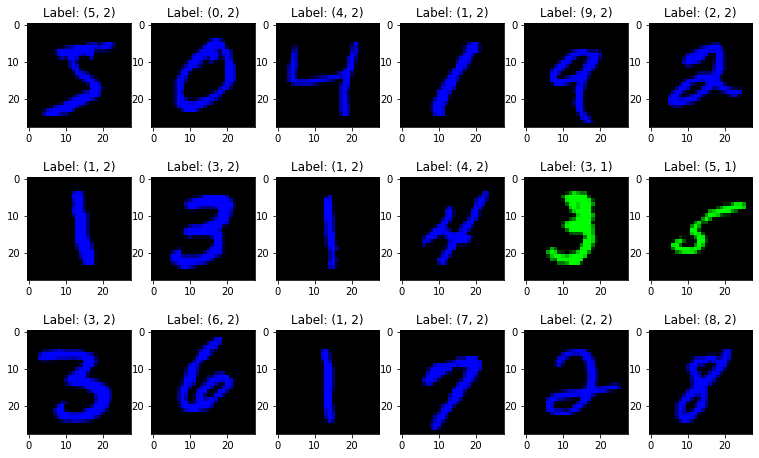

In [5]:
train1_set = ColoredMNIST(env='train1')
test_set = ColoredMNIST(env='test')
plot_dataset_digits(train1_set)

In [6]:
np.shape(train1_set[0][0])

(28, 28, 3)

Training 

In [7]:
class cvae(nn.Module):

    def __init__(self, image_size, hidden_dim, z_size, device, cond_dim, channel_num=3):
        super(cvae, self).__init__()

        self.label = "cvae"
        self.encoding_dim = z_size
        self.image_size = image_size
        self.hidden_dim = hidden_dim
        self.model_name = "cvae"
        self.vine = None
        self.z_size = z_size
        self.device = device
        self.channel_num = channel_num

        # Decoder - Fractional strided convolutional layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Sigmoid()  # nn.Tanh()
        )

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 0, bias=False),
            nn.Sigmoid()
        )

        # Fully-connected layers
        self.fc1 = nn.Linear(256 + cond_dim, self.hidden_dim)
        self.fc21 = nn.Linear(self.hidden_dim, self.encoding_dim)
        self.fc22 = nn.Linear(self.hidden_dim, self.encoding_dim)
        self.fc3 = nn.Linear(self.encoding_dim + cond_dim, self.hidden_dim)
        self.fc4 = nn.Linear(self.hidden_dim, 256)

    def decode(self, z, C):
        h3 = F.relu(self.fc3(torch.cat((z, C), dim=1)))
        h4 = torch.sigmoid(self.fc4(h3))
        return self.decoder(h4.view(z.size(0), -1, 1, 1))
    
    def encode(self, x, C):
        x = self.encoder(x).view(x.size(0),-1)
        return F.relu(self.fc1(torch.cat((x, C), dim=1)))  

    def forward(self, x, C):
        # Encode
        encoded = self.encode(x,C)

        # Obtain mu and logvar
        mu = self.fc21(encoded)
        logvar = self.fc22(encoded)

        # Reparametrization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)

        # Decode
        decoded = self.decode(z,C)

        # return decoded, mu, logvar
        return decoded, mu, logvar 

    def sample(self, size, C, noise=None):
        if noise is None:
            z = torch.randn(size, self.z_size).to(self.device)
        else:
            z = noise
        return self.decode(z,C)

    @property
    def name(self):
        return (
            'cvae'
            '-{kernel_num}k'
            '-{label}'
            '-{channel_num}x{image_size}x{image_size}'
        ).format(
            label=self.label,
            kernel_num=self.kernel_num,
            image_size=self.image_size,
            channel_num=self.channel_num,
        )

In [8]:
def idx2onehot(idx, n=10):

    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)

    return onehot

In [9]:
def calculate_loss(x, reconstructed_x, mean, log_var):
    # reconstruction loss
    l = torch.nn.MSELoss(reduction='sum')
    # kl divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return l(reconstructed_x,x) + KLD 

In [10]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x,(l,c)) in enumerate(all_train_loader):
        # reshape the data into [batch_size, 784]
        x = x.to(device)

        # convert label into one-hot encoding
        l = idx2onehot(l.view(-1, 1))
        l = l.to(device)

        # convert color into one-hot encoding
        c = idx2onehot(c.view(-1, 1),n=3)
        c = c.to(device)
        
        cond = torch.cat((l, c), dim=1)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        reconstructed_x, z_mu, z_var = model(x, cond)

        # loss
        loss = calculate_loss(x, reconstructed_x, z_mu, z_var)

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss


In [11]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x,(l,c)) in enumerate(test_loader):
            x = x.to(device)

            # convert label into one-hot encoding
            l = idx2onehot(l.view(-1, 1))
            l = l.to(device)

            # convert color into one-hot encoding
            c = idx2onehot(c.view(-1, 1),n=3)
            c = c.to(device)

            cond = torch.cat((l, c), dim=1)
            # forward pass
            reconstructed_x, z_mu, z_var = model(x, cond)

            # loss
            loss = calculate_loss(x, reconstructed_x, z_mu, z_var)
            test_loss += loss.item()

    return test_loss


In [12]:
HIDDEN_DIM=100
LATENT_DIM=30
CONDITIONAL_DIM=13
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cvae(32,HIDDEN_DIM,LATENT_DIM,device,CONDITIONAL_DIM)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
all_train_loader = torch.utils.data.DataLoader(
    ColoredMNIST(root='./data', env='all_train',transform=transforms.Compose([
                     transforms.ToPILImage(),
                     transforms.Resize(32),
                     transforms.ToTensor(),transforms.Normalize((0.1307, 0.1307, 0.), 
                                          (0.3081, 0.3081, 0.3081))])),
    batch_size=64, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    ColoredMNIST(root='./data', env='test', transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(32),
        transforms.ToTensor(),transforms.Normalize((0.1307, 0.1307, 0.),
                                                   (0.3081, 0.3081, 0.3081))])),
    batch_size=1000, shuffle=True, **kwargs)





Colored MNIST dataset already exists
Colored MNIST dataset already exists


In [ ]:
N_EPOCHS=1000
for e in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()


    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
    if e==0 :
        best_test_loss = test_loss +1

    if best_test_loss >= test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break

Epoch 0, Train Loss: 58862942.25, Test Loss: 22249777.38
Epoch 1, Train Loss: 41533874.02, Test Loss: 19444970.94
Epoch 2, Train Loss: 38150286.02, Test Loss: 18336762.56
Epoch 3, Train Loss: 36350326.44, Test Loss: 17627190.44
Epoch 4, Train Loss: 35224984.26, Test Loss: 17179652.25
Epoch 5, Train Loss: 34534756.25, Test Loss: 16927079.38
Epoch 6, Train Loss: 34105823.18, Test Loss: 16732725.12
Epoch 7, Train Loss: 33823384.18, Test Loss: 16622456.94
Epoch 8, Train Loss: 33599001.54, Test Loss: 16537785.00
Epoch 9, Train Loss: 33417308.95, Test Loss: 16467091.06
Epoch 10, Train Loss: 33273054.04, Test Loss: 16393854.88


In [ ]:
torch.save(model.state_dict(),"colorised_cvaeMSE_30S.pt")

In [ ]:
def cond(num,color=None):
    if(color==None):
        return idx2onehot(torch.tensor([num]).view(-1,1))
    else:
        # Red = 0    Green = 1     Blue = 2
        num = idx2onehot(torch.tensor([num]).view(-1,1))
        color = idx2onehot(torch.tensor([color]).view(-1,1),n=3)
        return torch.cat((num,color),dim=1)
        

In [ ]:
model = cvae(32,100,30,device,13)
model.load_state_dict(torch.load("colorised_cvaeMSE_30S.pt"))
model.eval()

for d in range(10):
    for c in range(3):
        with torch.no_grad():
            img = model.decode(torch.zeros(model.z_size).view(1,-1),cond(d,c))

        img = img.squeeze().numpy()
        img = np.rollaxis(img,0,3)
        plt.imshow(img)
        plt.show()

In [ ]:
for i, (x,(l,c)) in enumerate(test_loader):
    myx = x 
    break 

myx.shape

In [ ]:
for c in range(3):
    for d in range(10):
        img = model.decode(torch.zeros(model.z_size).view(1,-1),cond(d,c)).detach()
        img = img.squeeze().numpy()
        img = np.rollaxis(img,0,3)
        plt.imshow(img)
        plt.show()
        img = model.decode(torch.zeros(model.z_size).view(1,-1),cond(d,c)).detach()
        with torch.no_grad():
            img,_,_ = model(img,cond(d,c))
        img = img.squeeze().numpy()
        img = np.rollaxis(img,0,3)
        plt.imshow(img)
        plt.show()

In [ ]:
img = model.decode(torch.zeros(model.z_size).view(1,-1),cond(4,2)).detach()
img = img.squeeze().numpy()
img = np.rollaxis(img,0,3)
plt.imshow(img)
plt.show()
img = model.decode(torch.zeros(model.z_size).view(1,-1),cond(4,2)).detach()
with torch.no_grad():
    img,_,_ = model(img,cond(6,2))
img = img.squeeze().numpy()
img = np.rollaxis(img,0,3)
plt.imshow(img)
plt.show()

In [ ]:
model = cvae(32,100,2,device,10)
model.load_state_dict(torch.load("colorised_cvaeMSE_2MNOCCOLOR.pt"))
model.eval()

for d in range(10):
    with torch.no_grad():
        img = model.decode(torch.zeros(model.z_size).view(1,-1),cond(d))

    img = img.squeeze().numpy()
    img = np.rollaxis(img,0,3)
    plt.imshow(img)
    plt.show()

In [ ]:
for i, (x,(l,c)) in enumerate(test_loader):
    if(i==0):
        l = idx2onehot(l.view(-1, 1))
        c = idx2onehot(c.view(-1, 1),n=3)
        cond = torch.cat((l, c), dim=1)
        with torch.no_grad():
            p,_,_ = model(x,cond)
        break 

In [ ]:
for i in range(1000):
    img =p[i].numpy()
    img = np.rollaxis(img,0,3)
    plt.imshow(img)
    plt.show()